<a href="https://colab.research.google.com/github/gpufit/Comet/blob/master/Colab_notebooks/COMET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/gpufit/Comet/master/Python_interface/resources/comet_logo_small.png)

#Cost-function Optimized Maximal overlap drift EsTimation

COMET is a software package designed to correct drift in single molecule localization microscopy (SMLM) datasets with optimal spatial and temporal resolution.

Check out the Comet [github repository](https://github.com/gpufit/Comet) for  detailed information.

Note: to try Comet with a simple test dataset, a sample dataset is availble [here](https://raw.githubusercontent.com/gpufit/Comet/master/test_dataset/test_dataset.csv).


# How to use the Colab notebook

## Step 1: Environment setup (run once)

1.   Ensure that you are logged into your Google account.
2.   Select from the dropdown menu: File -> Save a Copy in Drive.
3.   Select from the dropdown menu: Edit -> Notebook Settings and ensure that GPU hardware acceleration is selected.
4.   Run the next 3 blocks of code (below) only once, by clicking the "Play" buttons one at a time, to finish setting up the remote hardware and software environment.


In [ ]:
# @title 1.1 Install Numba
!uv pip install -q --system numba-cuda==0.4.0

In [ ]:
# @title 1.2 Import Numba
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [ ]:
# @title 1.3 Function definitions
## Function definitions
import warnings
import numpy as np
from typing import Optional, Dict
from dataclasses import dataclass
from numba import cuda
import math
from scipy.optimize import minimize
import warnings
import time
from scipy.spatial import cKDTree
import h5py
from scipy.ndimage import convolve
#### Segmentation
@dataclass
class SegmentationResult:
    loc_segments: np.ndarray       # for each localization, which segment it belongs to
    loc_valid: np.ndarray          # boolean mask (True if that localization is “kept”)
    center_frames: np.ndarray      # average frame‐index of each segment
    n_segments: int                # total number of segments
    out_dict: Optional[Dict] = None

def _group_by_frame(loc_frames: np.ndarray):
    """Returns (unique_frames, frame_to_indices)"""
    sort_idx = np.argsort(loc_frames)
    sorted_frames = loc_frames[sort_idx]
    unique_frames, start_idx, counts = np.unique(
        sorted_frames, return_index=True, return_counts=True
    )
    frame_to_indices = {
        frame: sort_idx[start : start + count]
        for frame, start, count in zip(unique_frames, start_idx, counts)
    }
    return unique_frames, frame_to_indices

def segment_by_num_locs_per_window(
    loc_frames: np.ndarray,
    min_n_locs_per_window: int,
    max_locs_per_segment: Optional[int] = None,
    return_param_dict: bool = False,
) -> SegmentationResult:
    """
    Segments by collecting at least min_n_locs_per_window localizations per segment.
    Once that threshold is met (and there are still enough locs left for another segment),
    a new segment is created.
    """
    loc_frames = np.asarray(loc_frames, dtype=int)
    n_locs = len(loc_frames)

    unique_frames, frame_to_indices = _group_by_frame(loc_frames)
    loc_segments = np.full(n_locs, -1, dtype=int)
    segment_counter = 0
    n_locs_in_current_segment = 0
    current_segment_indices = []
    start_frames, end_frames, locs_per_segment = [], [], []

    for i, frame in enumerate(unique_frames):
        indices = frame_to_indices[frame]
        n_locs_this_frame = len(indices)
        remaining_locs = n_locs - (len(current_segment_indices) + n_locs_this_frame)

        # If adding this frame meets or exceeds the threshold AND
        # there are still >= min_n_locs_per_window locs left (or we are at the last frame),
        # then finalize the current segment and start a new one.
        if (
            (n_locs_in_current_segment + n_locs_this_frame >= min_n_locs_per_window)
            and (remaining_locs >= min_n_locs_per_window or i == len(unique_frames) - 1)
        ):
            current_segment_indices.extend(indices)
            n_locs_in_current_segment += n_locs_this_frame

            loc_segments[current_segment_indices] = segment_counter
            start_frames.append(loc_frames[current_segment_indices[0]])
            end_frames.append(loc_frames[current_segment_indices[-1]])
            locs_per_segment.append(len(current_segment_indices))

            segment_counter += 1
            current_segment_indices = []
            n_locs_in_current_segment = 0
        else:
            current_segment_indices.extend(indices)
            n_locs_in_current_segment += n_locs_this_frame

    n_segments = segment_counter
    center_frames = np.zeros(n_segments)
    loc_valid = np.zeros(n_locs, dtype=bool)

    for seg_id in range(n_segments):
        segment_indices = np.where(loc_segments == seg_id)[0]
        if max_locs_per_segment and len(segment_indices) > max_locs_per_segment:
            selected = np.random.choice(segment_indices, max_locs_per_segment, replace=False)
        else:
            selected = segment_indices
        loc_valid[selected] = True
        center_frames[seg_id] = np.mean(loc_frames[selected])

    out_dict = None
    if return_param_dict:
        n_locs_valid = loc_valid.sum()
        out_dict = {
            "n_segments": n_segments,
            "min_n_locs_per_window": min_n_locs_per_window,
            "frames_per_window": -1,
            "start_frames": np.array(start_frames),
            "end_frames": np.array(end_frames),
            "locs_per_segment": np.array(locs_per_segment),
            "n_locs": n_locs,
            "n_locs_valid": n_locs_valid,
            "n_locs_invalid": n_locs - n_locs_valid,
            "center_frames": center_frames,
        }

    return SegmentationResult(loc_segments, loc_valid, center_frames, n_segments, out_dict)

def segment_by_frame_windows(
    loc_frames: np.ndarray,
    n_frames_per_window: int,
    max_locs_per_segment: Optional[int] = None,
    return_param_dict: bool = False,
) -> SegmentationResult:
    """
    Splits localization data into fixed‐size windows of N frames.
    All localizations in those frames are grouped into one segment.
    """
    loc_frames = np.asarray(loc_frames, dtype=int)
    frames, frame_to_indices = _group_by_frame(loc_frames)
    n_locs = len(loc_frames)
    n_segments = int(np.ceil(len(frames) / n_frames_per_window))

    loc_segments = np.zeros(n_locs, dtype=int)
    center_frames = np.zeros(n_segments)
    loc_valid = np.ones(n_locs, dtype=bool)
    start_frames, end_frames, locs_per_segment = [], [], []

    for seg_id in range(n_segments):
        frame_window = frames[seg_id * n_frames_per_window : (seg_id + 1) * n_frames_per_window]
        # gather all indices for these frames
        indices = np.concatenate(
            [frame_to_indices[f] for f in frame_window if f in frame_to_indices]
        )
        if len(indices) == 0:
            continue
        loc_segments[indices] = seg_id
        start_frames.append(frame_window[0])
        end_frames.append(frame_window[-1])
        center_frames[seg_id] = np.mean(loc_frames[indices])
        locs_per_segment.append(len(indices))

        if max_locs_per_segment and len(indices) > max_locs_per_segment:
            mask = np.ones(len(indices), dtype=bool)
            mask[np.random.choice(len(indices), len(indices) - max_locs_per_segment, replace=False)] = False
            loc_valid[indices[~mask]] = False

    out_dict = None
    if return_param_dict:
        n_locs_valid = loc_valid.sum()
        out_dict = {
            "n_segments": n_segments,
            "min_n_locs_per_window": -1,
            "frames_per_window": n_frames_per_window,
            "start_frames": np.array(start_frames),
            "end_frames": np.array(end_frames),
            "locs_per_segment": np.array(locs_per_segment),
            "n_locs": n_locs,
            "n_locs_valid": n_locs_valid,
            "n_locs_invalid": n_locs - n_locs_valid,
            "center_frames": center_frames,
        }

    return SegmentationResult(loc_segments, loc_valid, center_frames, n_segments, out_dict)

def segment_by_num_windows(
    loc_frames: np.ndarray,
    n_windows: int,
    max_locs_per_segment: Optional[int] = None,
    return_param_dict: bool = False,
) -> SegmentationResult:
    """
    Converts a fixed number of windows into an equivalent minimum locs per window,
    then calls `segment_by_num_locs_per_window`.
    """
    n_locs = len(loc_frames)
    n_locs_per_window = int(np.ceil(n_locs / n_windows))
    return segment_by_num_locs_per_window(
        loc_frames, n_locs_per_window, max_locs_per_segment, return_param_dict
    )

def segmentation_wrapper(
    loc_frames: np.ndarray,
    segmentation_var: int,
    segmentation_mode: int = 2,
    max_locs_per_segment: Optional[int] = None,
    return_param_dict: bool = False,
) -> SegmentationResult:
    """
    Dispatch function that selects segmentation method:
      0 → fixed number of windows
      1 → fixed number of localizations per window
      2 → fixed number of frames per window (default)
    """
    if segmentation_mode == 0:
        return segment_by_num_windows(
            loc_frames, segmentation_var, max_locs_per_segment, return_param_dict
        )
    elif segmentation_mode == 1:
        return segment_by_num_locs_per_window(
            loc_frames, segmentation_var, max_locs_per_segment, return_param_dict
        )
    else:
        return segment_by_frame_windows(
            loc_frames, segmentation_var, max_locs_per_segment, return_param_dict
        )

### Finding Pairs
def pair_indices_kdtree(coordinates, distance):
    tree = cKDTree(coordinates)
    while True:
        try:
            pairs = tree.query_pairs(r=distance, output_type='ndarray')
            break
        except MemoryError:
            distance *= 0.8
            print(f"[pair_indices_kdtree] Reducing distance to {distance:.2f} due to memory error.")

    print(f"[pair_indices_kdtree] Found {len(pairs):,} pairs")
    return np.ascontiguousarray(pairs[:, 0], dtype=np.int32), np.ascontiguousarray(pairs[:, 1], dtype=np.int32)

### Drift correction

@cuda.jit
def cost_function_full_3d_chunked(d_locs_time, start_idx, chunk_size, d_idx_i, d_idx_j, d_sigma, d_sigma_factor, d_val,
                                  d_val_sum, d_deri, d_locs_coords, mu):
    tx = cuda.threadIdx.x
    ty = cuda.blockIdx.x
    bw = cuda.blockDim.x
    pos = tx + ty * bw

    if pos < chunk_size:
        i = d_idx_i[pos + start_idx]
        j = d_idx_j[pos + start_idx]

        ti = d_locs_time[i]
        tj = d_locs_time[j]

        dx = (d_locs_coords[i, 0] - mu[ti, 0]) - (d_locs_coords[j, 0] - mu[tj, 0])
        dy = (d_locs_coords[i, 1] - mu[ti, 1]) - (d_locs_coords[j, 1] - mu[tj, 1])
        dz = (d_locs_coords[i, 2] - mu[ti, 2]) - (d_locs_coords[j, 2] - mu[tj, 2])
        sigma_sq = (2 * d_sigma * d_sigma_factor) ** 2

        diff_sq = dx * dx + dy * dy + dz * dz
        val = 1 / (d_sigma * d_sigma_factor) * math.exp(-diff_sq / sigma_sq)
        d_val[pos] = val

        # Update derivatives
        cuda.atomic.add(d_deri, (tj, 0), 2 * val * (d_locs_coords[j, 0] - d_locs_coords[i, 0] + mu[ti, 0] - mu[tj, 0]) / sigma_sq)
        cuda.atomic.add(d_deri, (tj, 1), 2 * val * (d_locs_coords[j, 1] - d_locs_coords[i, 1] + mu[ti, 1] - mu[tj, 1]) / sigma_sq)
        cuda.atomic.add(d_deri, (tj, 2), 2 * val * (d_locs_coords[j, 2] - d_locs_coords[i, 2] + mu[ti, 2] - mu[tj, 2]) / sigma_sq)

        cuda.atomic.add(d_deri, (ti, 0), 2 * val * (d_locs_coords[i, 0] - d_locs_coords[j, 0] + mu[tj, 0] - mu[ti, 0]) / sigma_sq)
        cuda.atomic.add(d_deri, (ti, 1), 2 * val * (d_locs_coords[i, 1] - d_locs_coords[j, 1] + mu[tj, 1] - mu[ti, 1]) / sigma_sq)
        cuda.atomic.add(d_deri, (ti, 2), 2 * val * (d_locs_coords[i, 2] - d_locs_coords[j, 2] + mu[tj, 2] - mu[ti, 2]) / sigma_sq)

        cuda.atomic.add(d_val_sum, 0, val)
        d_val[pos] = 0


# Interface between the Python code and the CUDA kernel, mainly for chunking the data to avoid memory issues
def cuda_wrapper_chunked(mu, d_locs_coords, d_locs_time, d_idx_i, d_idx_j, d_sigma, d_sigma_factor, d_val, d_deri,
                         chunk_size):
    val_total = 0
    d_val_sum = cuda.to_device(np.zeros(1, dtype=np.float64))
    mu_dev = cuda.to_device(np.asarray(mu.reshape(int(mu.size / 3), 3), dtype=np.float64))

    n_chunks = int(np.ceil(d_idx_i.size / chunk_size))
    threadsperblock = 128

    for i in range(n_chunks - 1):
        idc_start = i*chunk_size
        blockspergrid = (chunk_size + (threadsperblock - 1)) // threadsperblock
        cost_function_full_3d_chunked[blockspergrid, threadsperblock](
            d_locs_time, idc_start, chunk_size, d_idx_i, d_idx_j,
            d_sigma, d_sigma_factor, d_val, d_val_sum, d_deri, d_locs_coords, mu_dev
        )
        val_total += d_val_sum.copy_to_host()

    # Final chunk
    n_remaining = d_idx_i.size - (n_chunks - 1) * chunk_size
    idc_start = (n_chunks - 1) * chunk_size
    blockspergrid = (n_remaining + (threadsperblock - 1)) // threadsperblock
    cost_function_full_3d_chunked[blockspergrid, threadsperblock](
        d_locs_time, idc_start, n_remaining, d_idx_i, d_idx_j,
        d_sigma, d_sigma_factor, d_val, d_val_sum, d_deri, d_locs_coords, mu_dev
    )
    val_total += d_val_sum.copy_to_host()
    deri = d_deri.copy_to_host()
    d_deri[:] = 0

    return -np.nansum(val_total), -deri.flatten()

def optimize_3d_chunked_better_moving_avg_kd(n_segments, locs_nm, sigma_nm=30, drift_max_nm=300,
                                             target_sigma_nm=30, display_steps=False,
                                             save_intermdiate_results=False,
                                             boxcar_width=3, drift_max_bound_factor=2,
                                             force_cpu=False, return_calc_time=False):

    intermediate_results_filehandle = None
    sigma_factor = 1.0

    # Find spatially close localization pairs
    idx_i, idx_j = pair_indices_kdtree(locs_nm[:, :3], drift_max_nm)

    # Extract coordinate + time arrays, convert to device if CUDA
    coords = locs_nm[:, :3].astype(np.float32).copy()
    times = locs_nm[:, 3].astype(np.int32).copy()

    chunk_size = int(1E8)  # 1E7

    if not force_cpu:
        d_coords = cuda.to_device(coords)
        d_times = cuda.to_device(times)
        if len(idx_i) * 4 > 2e9:
            # Use mapped memory if index arrays are large
            print("Large index arrays — using mapped memory.")
            d_idx_i = cuda.mapped_array_like(idx_i.astype(np.int32), wc=True)
            d_idx_j = cuda.mapped_array_like(idx_j.astype(np.int32), wc=True)
            d_idx_i[:] = idx_i
            d_idx_j[:] = idx_j
        else:
            d_idx_i = cuda.to_device(idx_i.astype(np.int32))
            d_idx_j = cuda.to_device(idx_j.astype(np.int32))
        # Preallocate device arrays
        d_sigma = np.float64(sigma_nm)
        d_val = cuda.to_device(np.zeros(chunk_size))
        d_deri = cuda.to_device(np.zeros((n_segments, 3), dtype=np.float64))
    else:
        # Fallback: CPU arrays
        d_coords = coords
        d_times = times
        d_sigma = sigma_nm
        d_idx_i, d_idx_j = idx_i, idx_j
        d_val = np.zeros(len(idx_i), dtype=np.float64)
        d_deri = np.zeros((n_segments, 3), dtype=np.float64)

    # Initial drift estimate + bounds
    drift_est = np.zeros(n_segments * 3)
    bounds = [(-drift_max_nm * drift_max_bound_factor, drift_max_nm * drift_max_bound_factor)] * (3 * n_segments)

    drift_est_gradient = np.inf
    fails = 0
    done = False
    itr_counter = 0
    start_time = time.time()

    wrapper = cuda_wrapper_chunked_cpu if force_cpu else cuda_wrapper_chunked
    print("Using CPU wrapper for optimization." if force_cpu else "Using CUDA wrapper for optimization.")
    print(f"Number of pairs: {len(idx_i)}")

    while not done:
        d_sigma_factor = np.float64(sigma_factor)
        # Apply boxcar smoothing to current estimate
        tmp = drift_est.reshape((-1, 3))
        for i in range(3):
            tmp[:, i] = convolve(tmp[:, i], np.ones(boxcar_width) / boxcar_width)
        drift_est = tmp.flatten()

        # Run L-BFGS-B optimization step
        result = minimize(wrapper, drift_est, method='L-BFGS-B',
                          args=(
                              d_coords, d_times, d_idx_i, d_idx_j, d_sigma, d_sigma_factor, d_val, d_deri, chunk_size),
                          jac=True, bounds=bounds,
                          options={'disp': display_steps, 'gtol': 1E-5, 'ftol': 1E3 * np.finfo(float).eps,
                                   'maxls': 40})
        itr_counter += 1
        print(f"Iteration {itr_counter}: status = {result.status}, success = {result.success}")
        print(f"  current sigma: {np.round(sigma_nm * sigma_factor, 2)} nm")

        # Optionally save intermediate result to HDF5
        if save_intermdiate_results:
            intermediate_results_filehandle = save_intermediate_results_wrapper(drift_est_nm=result['x'],
                                                                                locs_nm=locs_nm,
                                                                                sigma_nm=sigma_nm,
                                                                                sigma_factor=sigma_factor,
                                                                                itr_counter=itr_counter, fails=fails,
                                                                                filehandle=intermediate_results_filehandle)
        # Update if successful
        if result.success:
            delta = np.median((result.x - drift_est) ** 2)
            print(f"  drift estimate gradient: {delta}")
            print(f"  previous gradient: {drift_est_gradient}")
            # Check convergence
            if (delta > drift_est_gradient or sigma_nm * sigma_factor <= 1.0) and sigma_nm * sigma_factor <= target_sigma_nm:
                done = True
                calc_time = time.time() - start_time
                print(f"Optimization completed in {calc_time:.2f} s")
            else:
                sigma_factor /= 1.5
                drift_est_gradient = delta
                drift_est = result.x
        else:
            fails += 1
            if fails > 2:
                sigma_factor *= 2
                print("Restarting with larger sigma_factor")
            if fails > 5:
                raise RuntimeError("L-BFGS-B Optimization failed after multiple retries")

    if return_calc_time:
        return drift_est, time.time() - start_time, itr_counter
    else:
        return drift_est


def comet_run_kd(dataset, segmentation_result, max_locs_per_segment=None,
                 initial_sigma_nm=None, gt_drift=None, display=False, return_corrected_locs=False,
                 max_drift=None, target_sigma_nm=10, boxcar_width=1, drift_max_bound_factor=2,
                 save_corrected_locs=False, save_filepath=None, save_intermediate_results=False,
                 interpolation_method='cubic', force_cpu=False, min_max_frames=None):

    loc_frames = dataset[:, -1]


    # Apply segment IDs and mask out invalid localizations
    sorted_dataset = dataset.copy()
    sorted_dataset[:, -1] = segmentation_result.loc_segments
    sorted_dataset = sorted_dataset[segmentation_result.loc_valid]
    loc_frames = loc_frames[segmentation_result.loc_valid]

    # Set default max drift if not provided
    if initial_sigma_nm is None:
        initial_sigma_nm = 1/3 * max_drift

    # Run drift optimization
    t0 = time.time()
    drift_est = optimize_3d_chunked_better_moving_avg_kd(
        segmentation_result.n_segments, sorted_dataset,
        sigma_nm=initial_sigma_nm,
        target_sigma_nm=target_sigma_nm,
        drift_max_nm=max_drift,
        drift_max_bound_factor=drift_max_bound_factor,
        display_steps=display,
        boxcar_width=boxcar_width,
        save_intermdiate_results=save_intermediate_results,
        force_cpu=force_cpu
    )
    elapsed = time.time() - t0

    return drift_est





---



## Step 2: Import a dataset
As a first step, you need to import an SMLM dataset that you want to drift correct.  

There are TWO options:

*   Option 1:   Load a dataset from your local PC.  To upload a dataset from a local drive, click Run for the FIRST code block below.
*   Option 2:   Load a dataset from Google drive (faster).  For this option, enter the link to the dataset in the text box, and click Run on the SECOND code block below.


In [ ]:
# @title 2.1 Option 1: Upload a dataset from a local drive
from google.colab import files
file = files.upload()
import numpy as np
import pandas as pd
for key in file.keys():
  filename = key
import io
data = pd.read_csv(io.BytesIO(file[filename]))

localizations = np.zeros((len(data['frame']), 4))
localizations[:, 0] = np.asarray(data['x [nm]'])
localizations[:, 1] = np.asarray(data['y [nm]'])
try:
  localizations[:, 2] = np.asarray(data['z [nm]'])
except:
  localizations[:, 2] = 0
localizations[:, 3] = np.asarray(data['frame'])
frames = np.unique(localizations[:, -1])
n_frames = len(frames)
print(f"{filename} import successful, {len(localizations[:, 0])} localizations, {n_frames} frames")

"""
#How to import other formats?
#If you use a different data format, modify the lines of code so that you end up
#with a numpy array called localizations that has the following dimensions:
#
#localizations.shape = (number_of_localizations, dataset_dimension+1), where
#localizations[:, 0] are the x-coordinates etc. and localizations[:, -1] are the
#corresponding frames.

from google.colab import files
file = files.upload()

#Your import code here

assert (len(localizations[0,:])==3 or len(localizations[0,:])==4)
frames = np.unique(localizations[:, -1])
n_frames = len(frames)
"""

In [ ]:
# @title 2.2 Option 2: Load a dataset stored on Google drive
filename = "" # @param {"type":"string","placeholder":"test_dataset.csv"}

from google.colab import drive
drive.mount('/content/gdrive')
path_to_drive_files = "gdrive/MyDrive/"

import numpy as np
import pandas as pd

data = pd.read_csv(f"{path_to_drive_files}{filename}")

localizations = np.zeros((len(data['frame']), 4))
localizations[:, 0] = np.asarray(data['x [nm]'])
localizations[:, 1] = np.asarray(data['y [nm]'])
localizations[:, 2] = np.asarray(data['z [nm]'])
localizations[:, 3] = np.asarray(data['frame'])
frames = np.unique(localizations[:, -1])
n_frames = len(frames)
print(f"{filename} import successful, {len(localizations[:, 0])} localizations, {n_frames} frames")



---



## Step 3: Choose data segmentation options
In the next step, we choose how the dataset will be segmented into time windows.  The larger the number of windows, the higher the time resolution of the drift estimate.  Note: if the number of windows is too high, the accuracy of the estimate may degrade.

There are three options to segment the localization data:

* Option 1: **Choose the number of segments (N_seg):** divide the dataset into **N_seg** parts, each containing an equal number of localizations.
* Option 2: **Choose the number of localizations per segment (N_loc):** divide the dataset into equal parts, each containing **N_loc** localizations.
* Option 3: **Choose the number of camera frames per time window (N_frm):** divide the dataset into equal-length time segments, with **N_frm** per segment.  Note that if a segment contains zero localizations, the algorithm will fail.

Depending on which option is chosen, the **segmentation_parameter** corresponds to either **N_seg**, **N_loc**, or **N_frm**.

**Recommended setting: Option 2, with N_loc = 100-200 localizations per segment.**


In [ ]:
# @title 3.1 Run data segmentation

import numpy as np
from typing import Optional, Dict
from dataclasses import dataclass


# Example inputs (replace these with your actual vars in Colab):
segmentation_method = "segment by number of time windows" # @param ["segment by number of time windows","segments by number of locs per window","segment by number of frames per window"]
segmentation_parameter = 500                                # @param {type:"integer"}

# STEP A: pull out the 1‐D array of frame‐indices (must be ints)
loc_frames = localizations[:, -1].astype(int)

# STEP B: map the old‐style string → “mode” integer for the new API
mode_map = {
    "segment by number of time windows":          0,   # → segment_by_num_windows
    "segments by number of locs per window":      1,   # → segment_by_num_locs_per_window
    "segment by number of frames per window":     2,   # → segment_by_frame_windows
}
if segmentation_method not in mode_map:
    raise ValueError(f"No such segmentation method: {segmentation_method!r}")
min_frame = np.min(loc_frames)
max_frame = np.max(loc_frames)
seg_mode = mode_map[segmentation_method]
seg_result = segmentation_wrapper(loc_frames, segmentation_parameter,
                                  mode_map[segmentation_method], return_param_dict=True)



---



## Step 4: Set the Maximum drift parameter (**max_drift**)
Choose an estimate (guess) of the maximum distance which the sample may have drifted during the acquisition.  This number does not need to be exact, but it must be set larger than the true drift in the dataset.

If the Maximum drift is chosen too small, the output of COMET will exhibit artifacts (large jumps in the estimated drift).

If the Maximum drift is chosen too large, COMET may take a very long time to run, or may report a memory error.

**Recommended setting: for typical SMLM experiments, max_drift = 500nm - 2000nm.**

In [ ]:
#@title 4.1 Set Maximum Drift
max_drift_nm = 100#@param {type:"number"}
max_drift_nm = float(max_drift_nm)



---



## Step 5: Run the COMET algorithm

Run the next code block to use COMET to estimate the drift of your segmented localizations.

In [ ]:
# @title 5.1 Run COMET
t = time.time()
warnings.filterwarnings("ignore")

drift = comet_run_kd(localizations, seg_result,
                     max_drift=max_drift_nm)
drift = drift.reshape(seg_result.n_segments, 3)

print(f"algortihm done in {np.round(time.time()-t)}s")



---



## Step 6: Display and download the results

The COMET algorithm is complete!  Below are the options to inspect the results and download them for later use.

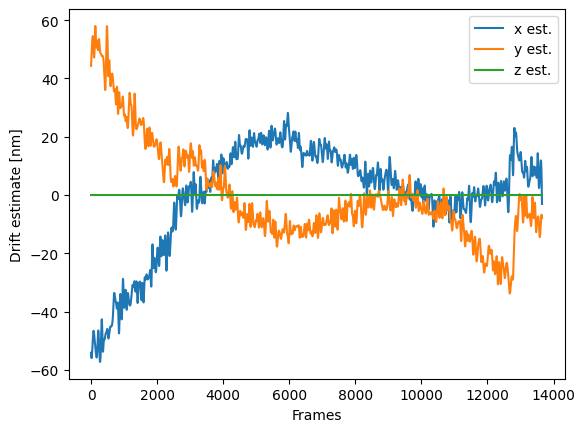

In [ ]:
#@title 6.1 Plot COMET drift estimate
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
#interpolate_drift = True #@param {type:"boolean"}
interpolate_drift = True
if not interpolate_drift:
  plt.plot(seg_result.center_frames, drift[:,0])
  plt.plot(seg_result.center_frames, drift[:,1])
  plt.plot(seg_result.center_frames, drift[:,2])
  plt.xlabel("Segments")
  plt.ylabel("Drift estimate [nm]")
else:
  dim = len(drift[0,:])
  drift_spline = np.zeros((max_frame+1, dim))
  for i in range(dim):
      spline_model = CubicSpline(seg_result.center_frames, drift[:, i])
      full_frames = np.arange((max_frame+1))
      drift_spline[:, i] = spline_model(full_frames)
  plt.plot(full_frames, drift_spline[:, 0])
  plt.plot(full_frames, drift_spline[:, 1])
  plt.plot(full_frames, drift_spline[:, 2])
  plt.xlabel("Frames")
  plt.ylabel("Drift estimate [nm]")
plt.legend(["x est.", "y est.", "z est."])

In [ ]:
# @title 6.2 Save the COMET drift estimate as CSV
from google.colab import files
import pandas as pd
if not interpolate_drift:
  drift_spline = drift
  full_frames = seg_result.center_frames


result = np.zeros((len(drift_spline[:, 0]), 4))
result[:, 1] = drift_spline[:, 0]
result[:, 2] = drift_spline[:, 1]
result[:, 3] = drift_spline[:, 2]
result[:, 0] = full_frames
header = "frame,x_nm,y_nm,z_nm\n"

df = pd.DataFrame(result, columns=["frame", "x_nm", "y_nm", "z_nm"])
df.to_csv("drift_trajectory_result.csv", index=False, sep=",")
files.download('drift_trajectory_result.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title 6.3 Download drift-corrected SMLM dataset as CSV
from google.colab import files
import pandas as pd
if not interpolate_drift:
  drift_spline = drift
  full_frames = seg_result.center_frames

header = "frame,x_nm,y_nm,z_nm\n"

dataset_corrected = np.zeros_like(localizations)
for i in range(3):
  dataset_corrected[:, i+1] = localizations[:, i] - drift_spline[localizations[:, -1].astype(int), i]
dataset_corrected[:, 0] = localizations[:, -1]
df = pd.DataFrame(dataset_corrected, columns=["frame", "x [nm]", "y [nm]", "z [nm]"])
df.to_csv("corrected_dataset.csv", index=False, sep=",",
              float_format = '%.3f')
files.download('corrected_dataset.csv')